In [1]:
!nvidia-smi

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Tue Jul  2 08:54:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:41:00.0 Off |                  Off |
| 30%   28C    P8               9W / 230W |  22938MiB / 24564MiB |      0%      Default |
|                                         |                      |                  

In [2]:
import numpy as np
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

2.2.2 0.17.2
Files already downloaded and verified
Running on cuda:4
GT label is 2. 
Onehot label is 2.
Dummy label is 9.
0, 640.2688598632812
30, 45.6158561706543
60, 32.599002838134766
90, 31.759361267089844
120, 32.07560348510742
150, 29.351882934570312
180, 24.075790405273438
210, 21.794273376464844
240, 23.030704498291016
270, 19.473112106323242
300, 28.618684768676758
330, 24.041940689086914
360, 21.61448097229004
390, 19.575593948364258
420, 19.823259353637695
450, 18.84681510925293
480, 22.390079498291016
510, 24.010662078857422
540, 19.222383499145508
570, 20.538455963134766
600, 20.886520385742188
630, 21.55288314819336
660, 23.95137596130371
690, 20.38996124267578
720, 22.981456756591797
750, 23.48989486694336
780, 25.33112335205078
810, 18.336349487304688
840, 19.1428165435791
870, 22.348674774169922
idx = 791, len = 18000
Dummy label is 2.
Files already downloaded and verified
Running on cuda:4
GT label is 2. 
Onehot label is 2.
Dummy label is 0.
0, 738.3102416992188
30, 1

/tmp/ipykernel_1971345/2351939666.py:158: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


idx = 776, len = 13017
Dummy label is 6.


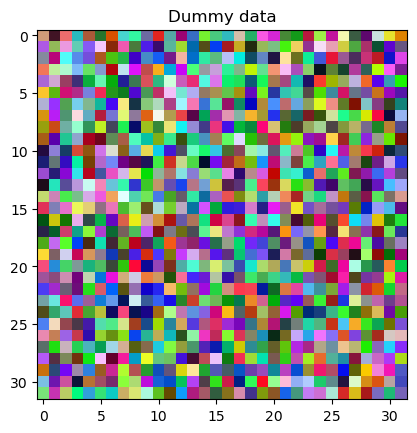

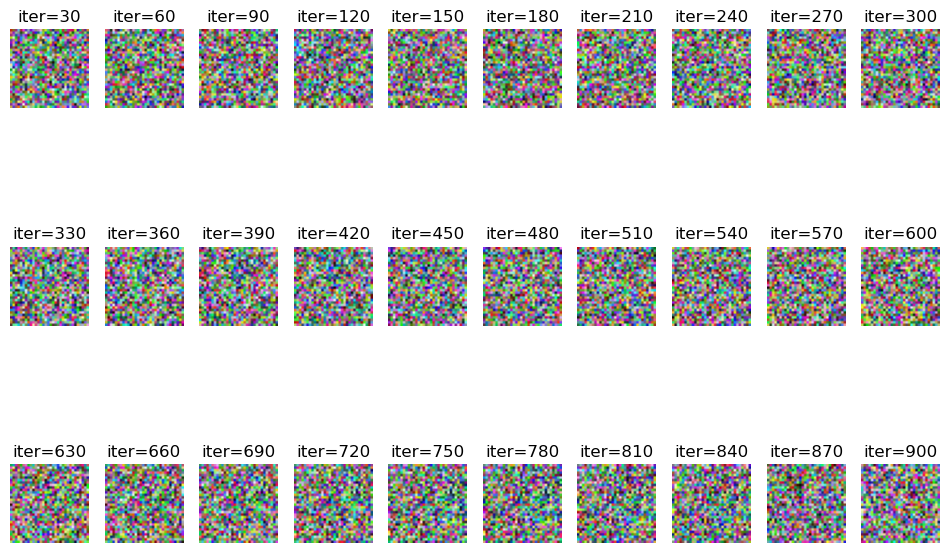

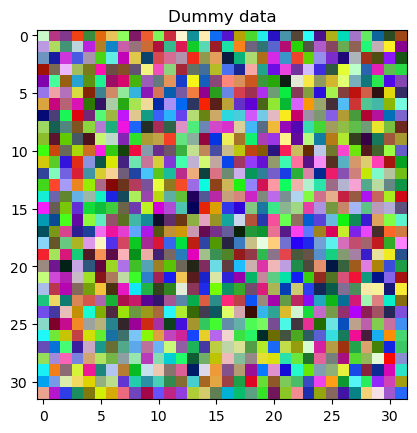

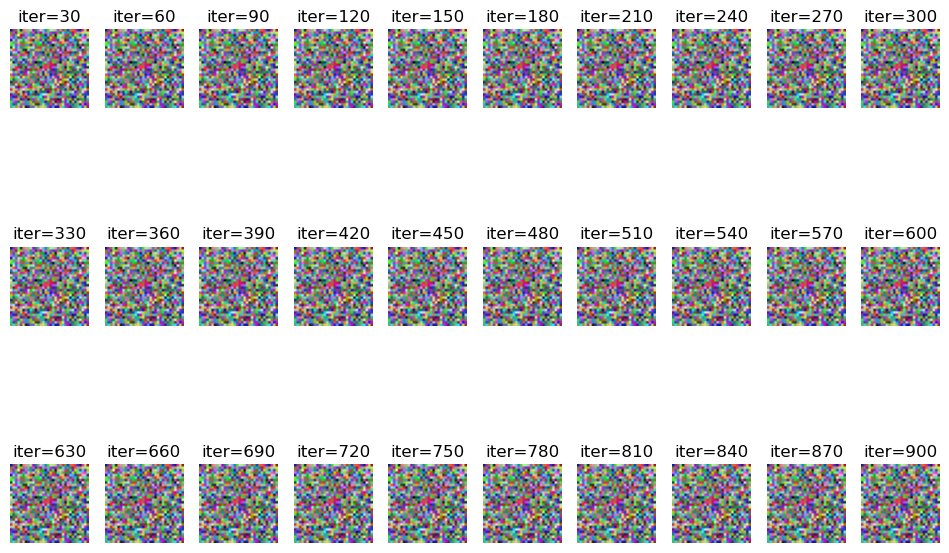

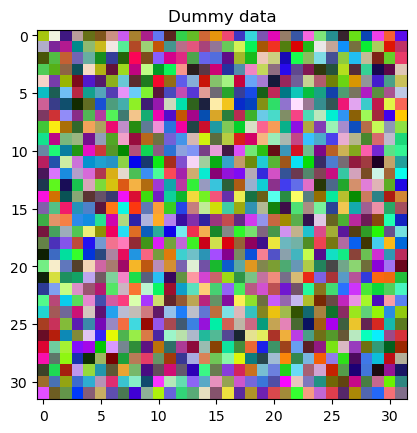

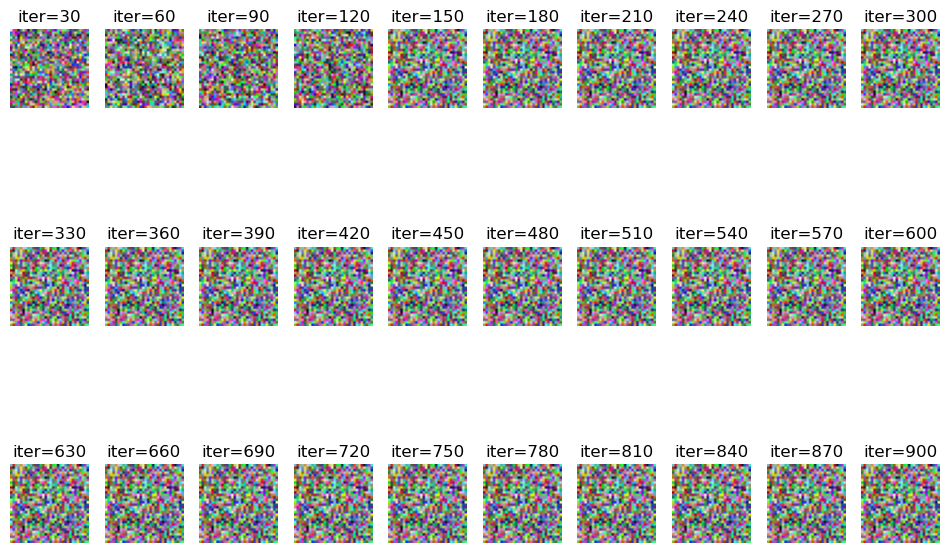

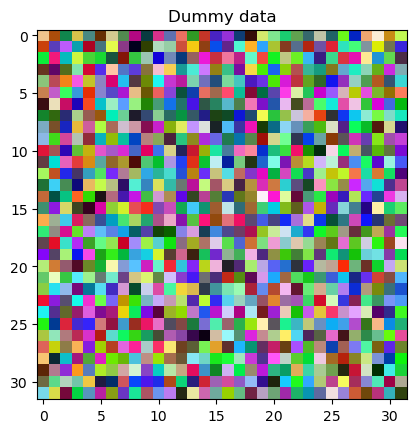

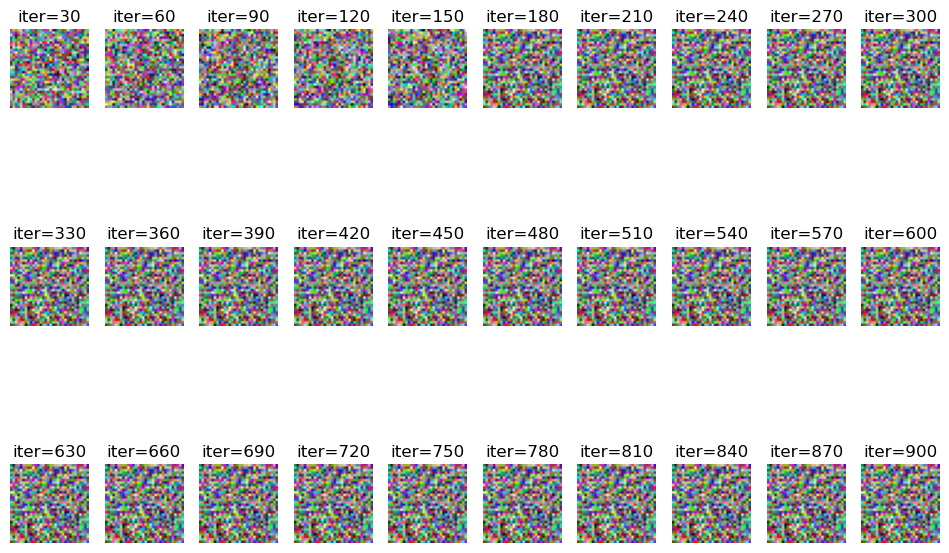

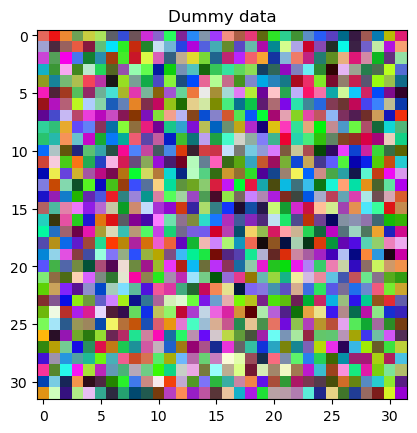

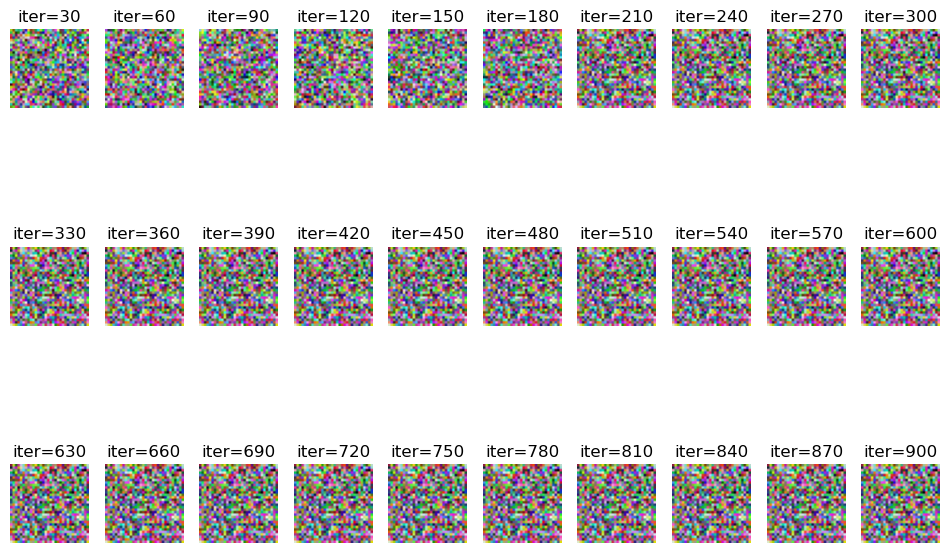

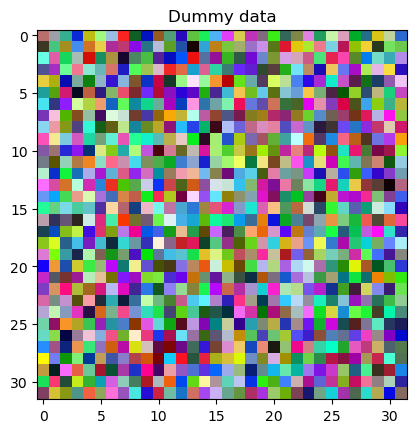

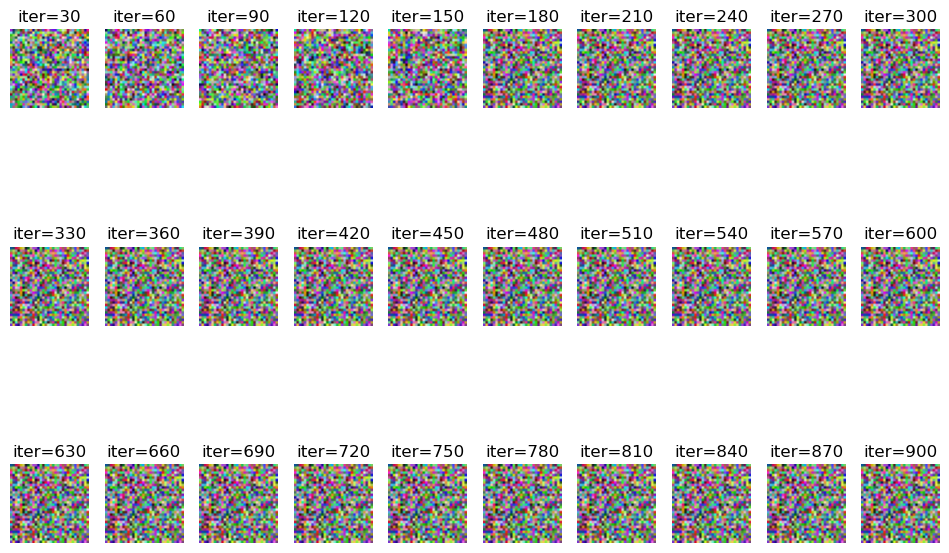

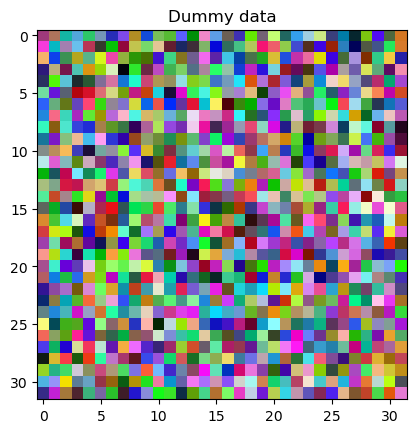

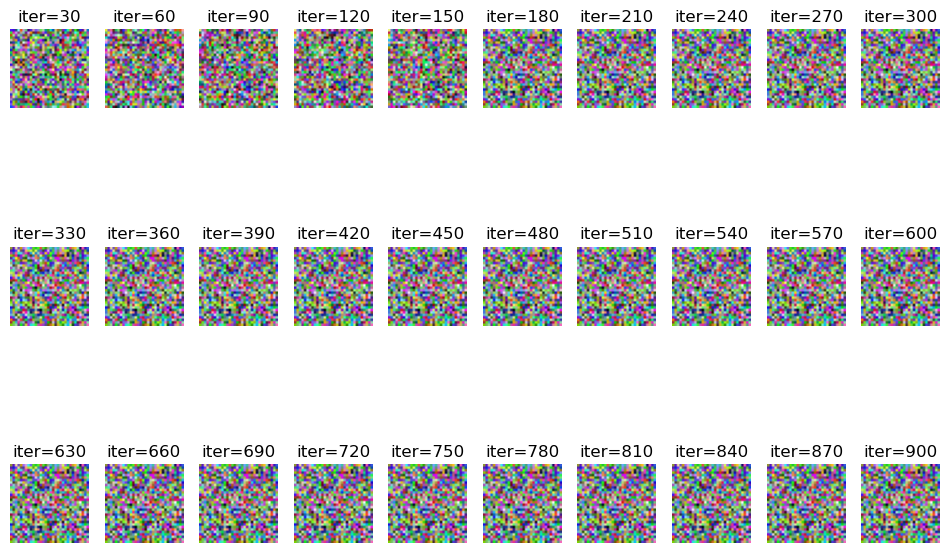

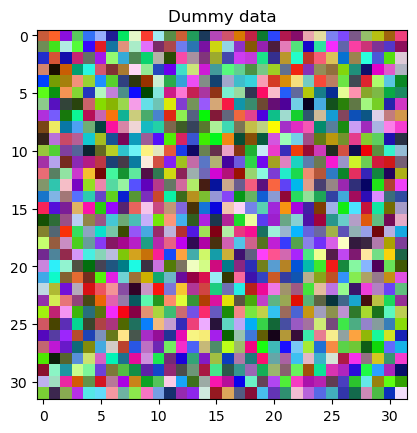

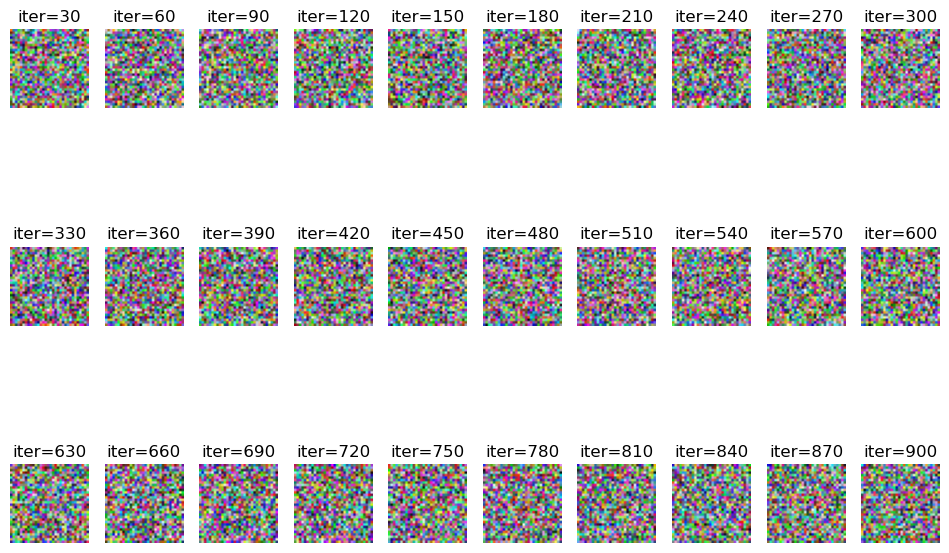

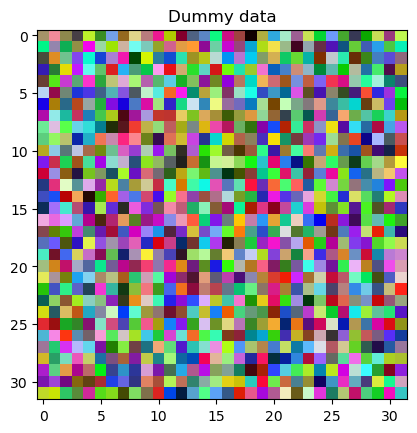

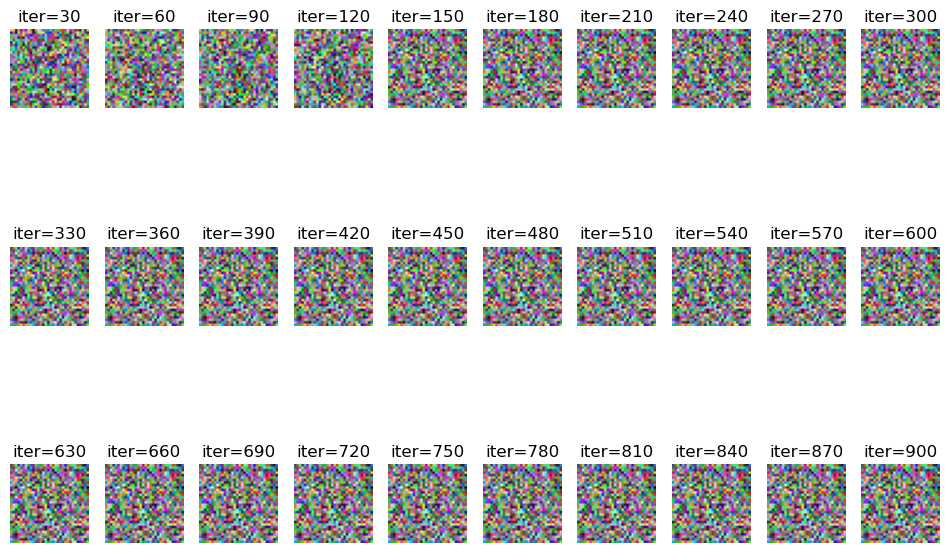

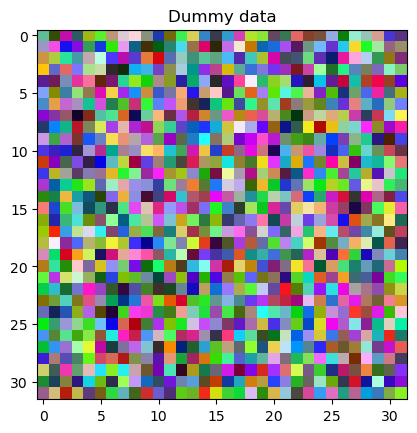

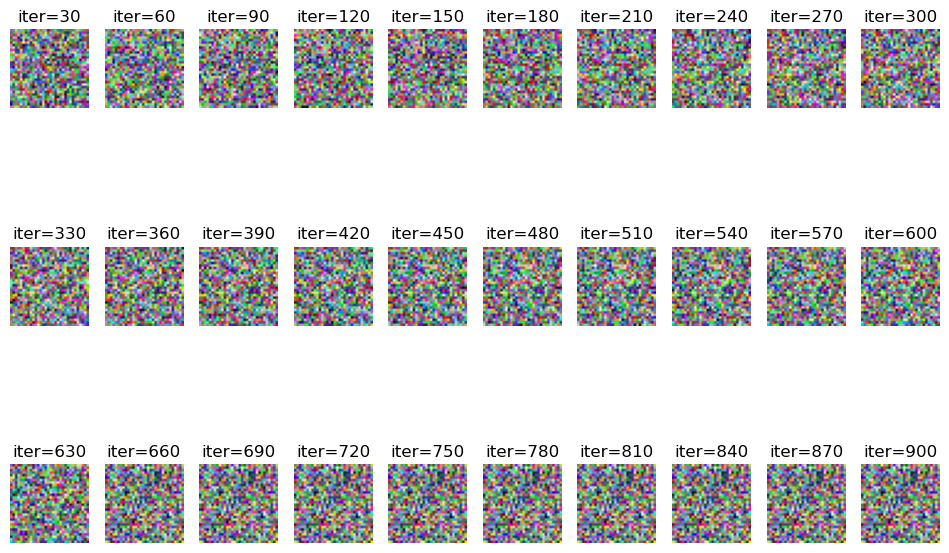

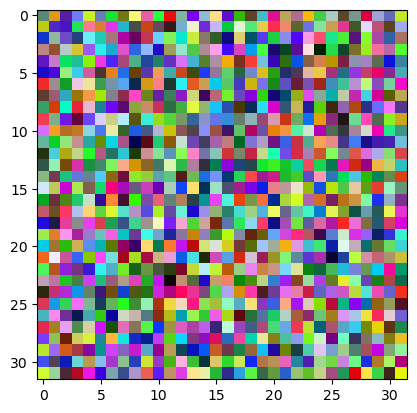

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__, torchvision.__version__)
for tid in range(10):
    interval = 30
    class_num = 10
    protected_layers = []  # No specific layers to protect initially
    dst = datasets.CIFAR10("~/.torch", download=True)
    tp = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])
    tt = transforms.ToPILImage()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:4"  # Changed to cuda:0 for general usage
    print("Running on %s" % device)

    def label_to_onehot(target, num_classes=class_num):
        target = torch.unsqueeze(target, 1)
        onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
        onehot_target.scatter_(1, target, 1)
        return onehot_target

    def cross_entropy_for_onehot(pred, target):
        return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

    def weights_init(m):
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)

    class LeNet(nn.Module):
        def __init__(self):
            super(LeNet, self).__init__()
            act = nn.Sigmoid
            self.body = nn.Sequential(
                nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
                act(),
            )
            self.fc = nn.Sequential(
                nn.Linear(768, class_num)
            )

        def forward(self, x):
            out = self.body(x)
            out = out.view(out.size(0), -1)
            out = self.fc(out)
            return out

    net = LeNet().to(device)

    net.apply(weights_init)
    criterion = cross_entropy_for_onehot

    img_index = 55
    gt_data = tp(dst[img_index][0]).to(device)
    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=class_num)
    plt.imshow(tt(gt_data[0].cpu()))
    plt.title("Ground truth image")
    print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    out = net(gt_data)
    y = criterion(out, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())

    def mask_gradients(dy_dx, exposure_ratio=99/100):
        flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
        total_params = len(flattened_grads)
        exposed_params = int(total_params * exposure_ratio)

        mask = torch.zeros(total_params, device=flattened_grads.device)
        mask[:exposed_params] = 1
        mask = mask[torch.randperm(total_params)]

        masked_grads = []
        start = 0
        for g in dy_dx:
            numel = g.numel()
            g_flat = g.view(-1)
            masked_g_flat = g_flat * mask[start:start+numel]
            masked_grads.append(masked_g_flat.view_as(g))
            start += numel

        return tuple(masked_grads)

    dy_dx = mask_gradients(dy_dx)

    original_dy_dx = list((_.detach().clone() for _ in dy_dx))

    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

    history = []
    losses = []
    for iters in range(30*interval):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            dummy_dy_dx = mask_gradients(dummy_dy_dx)

            grad_diff = 0
            grad_count = 0

            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()

            grad_diff.backward()
            losses.append(grad_diff.item())
            return grad_diff

        optimizer.step(closure)
        if iters % interval == 0:
            print(f"{iters}, {losses[iters]}")
        history.append(tt(dummy_data[0].cpu()))

    plt.figure(figsize=(12, 8))
    for i in range(30):
        ite_num = i * interval + interval - 1
        plt.subplot(3, 10, i + 1)
        plt.imshow(history[ite_num])
        plt.title("iter=%d" % (ite_num+1))
        plt.axis('off')

    filename = 'CIFAR'+str(class_num)+'_'+ str(30*interval) + 'ite_' + str(protected_layers) + '_' +'.png'
    plt.savefig(filename)

    plt.figure()
    loss = min(losses[0:interval * 30 - 1])
    idx = losses.index(loss)
    print(f"idx = {idx}, len = {len(losses)}")
    plt.imshow(history[idx])
    filename = 'single_' + filename
    plt.savefig(filename)

    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())


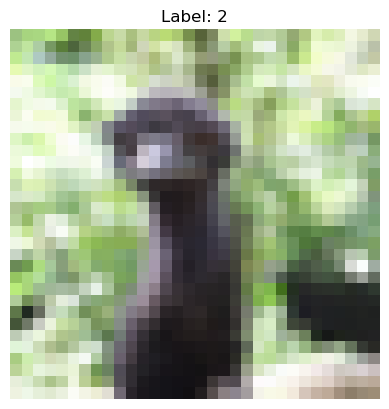

In [16]:
# Get a sample image and its label
image, label = dst[55]

# Display the image using matplotlib
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')  # Hide axes
plt.show()

GT label is 2. 
Onehot label is 2.


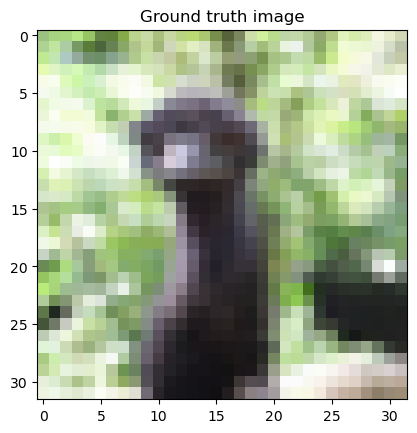

In [17]:
plt.imshow(tt(gt_data[0].cpu()))
# file_gt = "gt.png"
# plt.savefig(file_gt)
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())